# Clustering Consulting Project 

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? It's probably not possible to know for sure, but maybe what you've just learned about Clustering can help!

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import findspark
findspark.init("/home/rajdeep/spark-3.5.0-bin-hadoop3/")

In [3]:
from pyspark.sql import SparkSession

In [4]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
#initalizing the spark object
spark = SparkSession.builder.appName("hack").getOrCreate()

In [9]:
#reading the data into dataframe
df = spark.read.csv("data/hack_data.csv", inferSchema=True, header=True)

In [10]:
df.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [23]:
df.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       NULL|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       NULL| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

In [12]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [13]:
#initializing the VectorAssembler to create feature vector for ML model
assembler = VectorAssembler(inputCols=['Session_Connection_Time','Bytes Transferred','Kali_Trace_Used','Servers_Corrupted',
 'Pages_Corrupted','WPM_Typing_Speed'], outputCol='feature')
#creating the new column with vector of required row data
df = assembler.transform(df)

In [14]:
#initializing the StandardScaler so as all the feature are in same range
scaler = StandardScaler(inputCol='feature', outputCol='scaled_feature')
#creating the new column with scaled vector of required row data
df = scaler.fit(df).transform(df)

In [15]:
#finding elbow to find optimal value of cluster
cost = np.zeros(10)

for k in range(2,10):
    kmean = KMeans(seed=1,featuresCol='scaled_feature',k=k)
    model = kmean.fit(df)
    cost[k] = model.summary.trainingCost


cost_df = pd.DataFrame(cost[2:])
cost_df.columns = ['cost']
cluster_li = [i for i in range(2,10)]
cost_df.insert(0,'cluster',cluster_li)

23/12/03 13:11:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


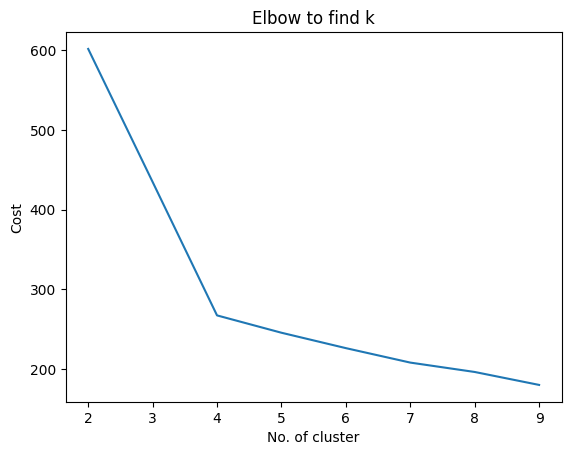

In [16]:
#plotting the WCSS value
plt.plot(cost_df['cluster'],cost_df['cost'])
plt.xlabel('No. of cluster')
plt.ylabel('Cost')
plt.title('Elbow to find k')
plt.show()

In [17]:
# Elbow method is giving proper answer as we know it either 2 or3 hacker not 4
# We can transform data and then check which isgiving equal number of points in each cluster as we know they are equally distributed

In [18]:
#initializing the model as well fitting and predicting the value
kmean = KMeans(seed=1,featuresCol='scaled_feature',k=2)
df_2 = kmean.fit(df).transform(df)

In [19]:
df_2.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [20]:
#initializing the model as well fitting and predicting the value
kmean = KMeans(seed=1,featuresCol='scaled_feature',k=3)
df_3 = kmean.fit(df).transform(df)

In [21]:
df_3.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   79|
|         0|   88|
+----------+-----+



In [22]:
# hence we are sure there were only 2 hackers